In [1]:
import pandas as pd, psycopg2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def query_database(connection, sql, *args, **kwargs):
    if connection.get_transaction_status() == 3:
        connection.reset()
    with connection.cursor() as cursor:
        cursor.execute(sql, *args, **kwargs)
        rows = cursor.fetchall()
        columns = [d[0] for d in cursor.description]
    df = pd.DataFrame(rows, columns=columns)
    return df

In [3]:
connection = psycopg2.connect('postgres://fga@localhost/fga')

In [8]:
sql = '''
with events_ as (
    select
        "createdAt" as ts,
        "currentUser" as user_id,
        "userDevice" as device_id
        
    from events
    
), devices_ as (
    select
        "Id" as device_id,
        "DeviceOS" as client,
        "UserID" as user_id,
        "CreatedAt" as created_at
        
    from devices
    
), device_count as (
    select
        user_id,
        device_id,
        client,
        created_at,
        row_number() over (partition by user_id order by created_at) as device_count
        
    from devices_
    
    order by 1

), users_ as (
    select
        user_id,
        device_id,
        client,
        created_at
        
    from device_count
    
    where device_count = 1

), cohort_sizes as (
    select
        created_at::date as date,
        client,
        count(distinct user_id) as cohort_size
        
    from users_
    
    group by 1, 2
    
    order by 1, 2
        
), w1_active_users as (
    select
        created_at::date as date,
        client,
        count(distinct events_.user_id) as w1_active_users
        
    from events_ join users_ using (user_id)
        
    where ts::date >= created_at::date + 7
        and ts::date < created_at::date + 14
    
    group by 1, 2
    
), w1_retention as (
    select
        date,
        client,
        w1_active_users::float / cohort_size * 100 as w1_retention
        
    from w1_active_users l
        join cohort_sizes
            using (date, client)
    
), w2_active_users as (
    select
        created_at::date as date,
        client,
        count(distinct events_.user_id) as w2_active_users
        
    from events_ join users_ using (user_id)
        
    where ts::date >= created_at::date + 14
        and ts::date < created_at::date + 21
    
    group by 1, 2
    
), w2_retention as (
    select
        date,
        client,
        w2_active_users::float / cohort_size * 100 as w2_retention
        
    from w2_active_users
        join cohort_sizes
            using (date, client)
    
), w3_active_users as (
    select
        created_at::date as date,
        client,
        count(distinct events_.user_id) as w3_active_users
        
    from events_ join users_ using (user_id)
        
    where ts::date >= created_at::date + 21
        and ts::date < created_at::date + 28
    
    group by 1, 2
    
), w3_retention as (
    select
        date,
        client,
        w3_active_users::float / cohort_size * 100 as w3_retention
        
    from w3_active_users
        join cohort_sizes
            using (date, client)
    
), w4_active_users as (
    select
        created_at::date as date,
        client,
        count(distinct events_.user_id) as w4_active_users
        
    from events_ join users_ using (user_id)
        
    where ts::date >= created_at::date + 28
        and ts::date < created_at::date + 35
    
    group by 1, 2
    
), w4_retention as (
    select
        date,
        client,
        w4_active_users::float / cohort_size * 100 as w4_retention
        
    from w4_active_users
        join cohort_sizes
            using (date, client)
    
), results as (
    select
        date,
        client,
        w1_retention,
        w2_retention,
        w3_retention,
        w4_retention
        
    from w1_retention 
        left join w2_retention using (date, client)
        left join w3_retention using (date, client)
        left join w4_retention using (date, client)

)

select * from results
'''

df = query_database(connection, sql)
df.head()

,date,client,w1_retention,w2_retention,w3_retention,w4_retention
0,2019-10-01,Android,11.363636,23.484848,18.939394,12.878788
1,2019-10-01,iOS,7.586207,15.862069,15.862069,15.172414
2,2019-10-02,Android,12.800000,12.800000,11.200000,11.200000
3,2019-10-02,iOS,8.870968,12.903226,11.290323,7.258065
4,2019-10-03,Android,15.384615,25.174825,16.083916,13.286713


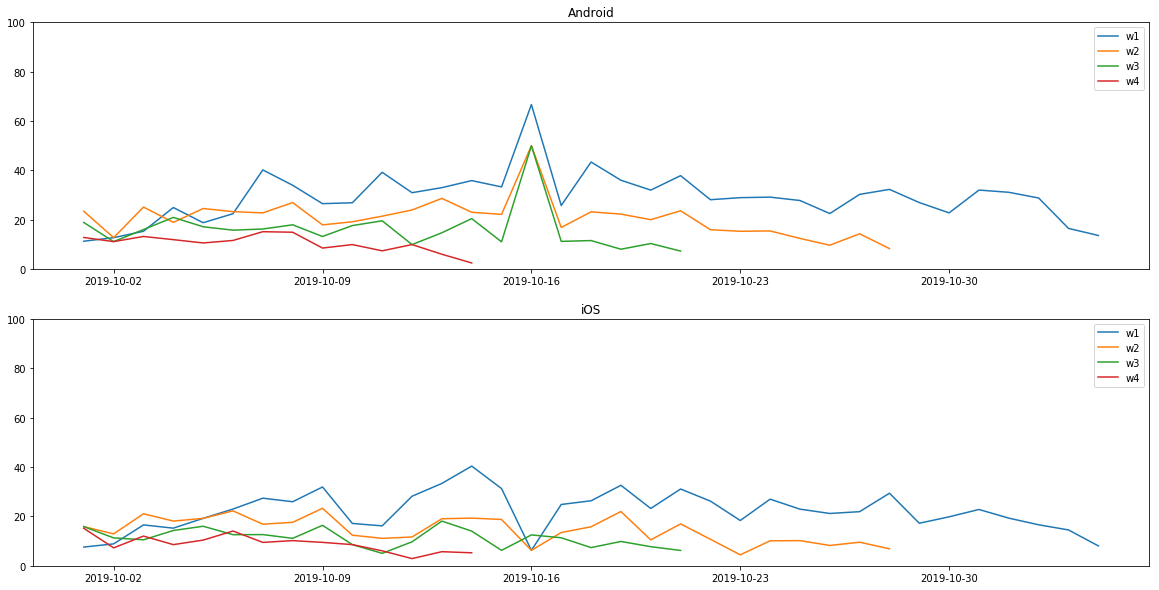

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
for i, (client, df_) in enumerate(df.groupby('client')):
    ax = axes[i]
    for w in [1, 2, 3, 4]:
        ax.plot(df_['date'], df_[f'w{w}_retention'], label=f'w{w}')
    ax.legend()
    ax.set_title(client)
    ax.set_ylim(0, 100)